### display gadget

In [1]:
from graphviz import Digraph
def show(e):
    g = Digraph(comment='Grundbegriffe')
    g.attr(shape='box')
    for a,b in e: 
        g.node(a, shape='box')
        g.node(b, shape='box')
        g.edge(a,b)
    return g

In [60]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# The Steinhaus Space

Let's take a look at this in Lean and then we will pick it apart to see what it all means.  

At the highest level description, the **Steinhaus space** is a **probability space**

$$(\Omega,{\mathscr A},P) = ([0,1], {\mathscr B}([0,1]), \lambda\restriction_{[0,1]})$$

where the **sample space** $\Omega$ is the **closed unit interval**

$$[0,1] = \{x : 0 \leq x \leq 1\}$$

and ${\mathscr A}$ is the **$\sigma$-algebra generated by $[0,1]$**

and $\lambda\restriction_{[0,1]}$ is the **Lebesgue measure** restricted to $[0,1]$ such that

$$\lambda([a,b]) = b-a$$

In Lean:

Before we go on, let's make a picture of the relationships in the above code:

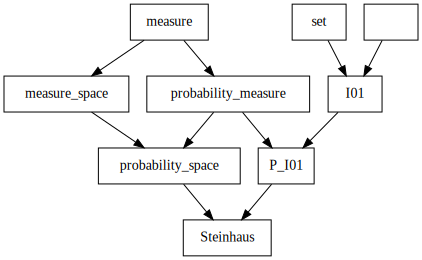

In [2]:
show([('probability_space', 'Steinhaus'),
   ('P_I01', 'Steinhaus'),
   ('measure_space', 'probability_space'),
   ('measure', 'probability_measure'),
   ('measure', 'measure_space'),
   ('probability_measure', 'probability_space'),
   ('probability_measure', 'P_I01'),
   ('I01', 'P_I01'),
   ('set', 'I01'),
   ('ℝ', 'I01')
  ])

We start by looking at the real numbers.  The real numbers have a rather complicated construction called the Dedekind cuts.  The construction of the reals is completely encoded in the Lean [mathlib](https://leanprover-community.github.io/mathlib_docs/).  For completeness' sake, we will probably get into it.  But we can work with a much simpler domain, such as the nontrivial set $\{0,1,2\}$, which will take less time to proof check and may be easier to think about.

So that's our study plan

* We will take a brief tour of this probability space for the reals
* We will replace this page will a simpler example involving a very simple finite set
* For the simpler example we will drill down to all the nitty gritty definitions
* Then we will come back to the reals and take the grand tour of the Dedekind cuts and Lebesgue measure and Lebesgue integral and all that stuff

So step 1, the brief tour of this page.  When we say `#check Steinhaus`, and Lean comes back with `probability_space ↥I01`, what we have established is that

* There is a proof
* Which checks
* That $[0,1]$ taken together with $\lambda\restriction_{[0,1]}$ is a **measure space**, and this **measure** is a **probability space**

In the code, $[0,1]$ is referred to as `I01`.  `I01` is defined as

`abbreviation I01 := (set.Icc (0 : ℝ) 1)`

OK so what is `set.Icc`?  It is [defined in Lean](https://github.com/leanprover-community/mathlib/blob/4e8486b807bec6f7e6f9d353e71ffaae630e8a9e/src/data/set/intervals/basic.lean#L47) as the set:

`/-- Left-closed right-closed interval -/
def Icc (a b : α) := {x | a ≤ x ∧ x ≤ b}`

and in particular we have fixed the type `α` to be the real numbers ℝ by setting `a` to be `0 : ℝ`.  This says I am looking for the `0` in the real numbers.  Since `b` is the same type as `a`, Lean's type inference mechanism infers that `b` is also real, and we get the real interval $[a,b]=[0,1]=\{x | 0 ≤ x ∧ x ≤ 1\}$.  So a lot of what Lean does can be summarized as 

* Type inference
* Term rewriting

OK so let's keep unpacking this.  We now need to know what we mean by

* Probability space
* Probability measure
* Measure space
* Measure

We will cover these concepts in exactly the wrong order: backwards.  I'm doing so on the assumption that you've probably kind of been here before.  We are going backwards because, at this stage, we are more interested in the Lean journey than the precise specifics of the definitional destination (although we do care about both).  So we will walk backward to see what it all means, and then we will walk forward with the singleton set example to set things in order again and go to a deeper level of detail tracing through how things work in the forward direction.

Working backwards, we see that `Steinhaus` is an **instance** of `probability_space`:

`
instance Steinhaus : probability_space I01 := 
{ is_probability_measure := P_I01 }
`
and this instance has probability measure `P_I01`.

What is means to be an "instance" in Lean is fairly complicated.  An instance is a type, and it is a more specific version of a more general type.  The more general type is called a "type class".  To learn this and many more details, please read and interact with [Theorem Proving in Lean](https://leanprover.github.io/theorem_proving_in_lean/), in your free time.  (In particular, chapter 10 for type classes.)  It's well worth the journey.  I won't emphasize many of the fine-grained details you can see there.  I will stick with the big picture for this discussion.  Suffice it to say that, when a `probability_space` is needed, the type inference mechanism of Lean will look for instances of that type which have been constructed, which will fit into the context where the instance is being called for.

#### probability space

```
class probability_space (α : Type*) extends measure_space α :=
(is_probability_measure:  probability_measure volume)
```

What this says is that a `probability_space` is a `measure_space` with a **measure** (called `volume`) which is a `probability_measure`.

#### probability_measure
A measure `μ` is called a probability measure if `μ univ = 1`.

```
class probability_measure (μ : measure α) : Prop := (measure_univ : μ univ = 1)
```

What this says is that if $(X,\mu)$ is the measure space, with **carrier set** $X$ and **measure** $\mu$ (which operates on *sets*; recall that $[0,1]$ is a set), is such that

$$\mu(X) = 1$$

We will go into more detail on `measure` a little later in the talk.

## Foundational and finite types in Lean

As we go along it will be helpful to construct some motivating examples.  To do so we will make smallest nontrivial instances or examples where possible.

### universe, Type, Sort

Lean has an infinite hierarchy of universes of types:

```
#check Type     -- Type 0
#check Type 1   -- Type 1
#check Type 2   -- Type 2
#check Type 3   -- Type 3
```
The ordinary types are members of `Type 0`.  `Type 1` contains `Type 0` as an element, and so on.  If we want to abstract over type levels 0,1,2 and so on (called **universes**), we can introduce a universe variable `u`.  A `Sort u` is a member of `Type u`.  So:
```
universe u
variable α : Sort u
#check Sort u -- Sort u : Type u
#check α -- α : Sort u
```
All of this is called **dependent type theory**.  This is described in more detail [here](https://leanprover.github.io/theorem_proving_in_lean/dependent_type_theory.html).

### Natural numbers $ℕ=0,1,2,3....$

The natural numbers are defined very simply as the inductive type

```
inductive nat
| zero : nat
| succ (n : nat) : nat
```

This says that a natural number is either 0 or a successor of another natural number.

A lot of additional definitions in Lean sugar this so that we can write natural numbers as positive integers, so these all work:

```
#check nat.zero -- 0 : ℕ
#check 0 -- 0 : ℕ

#reduce nat.zero -- 0
#reduce 0 -- 0

#check nat.succ(nat.zero) -- 1 : ℕ
#check 1 -- 1 : ℕ
```

Fortunately or unfortunately, this also has the effect of hiding the mechanics, so we don't see 1 printed as say `0.succ`.  We can say the mechanics a little bit with some expressions that don't get sugared, for example:
```
#check nat.succ(1) -- 1 : ℕ
#reduce nat.succ(1) -- 2
```

### Prop

`Prop` is the type of provable propositions.  Elements of `Prop` are **proofs** of the given proposition.

### equivalence

An equivalence relation $a < b$ between $a$ and $b$ is a reflexive, symmetric and transitive relation.
```
variables {α : Sort u} {β : Sort v} (r : β → β → Prop)
local infix `≺`:50 := r

def reflexive := ∀ x, x ≺ x

def symmetric := ∀ ⦃x y⦄, x ≺ y → y ≺ x

def transitive := ∀ ⦃x y z⦄, x ≺ y → y ≺ z → x ≺ z

def equivalence := reflexive r ∧ symmetric r ∧ transitive r
```

### Lists of elements of a single type $L=[a,b,c,\ldots]$

Lists are defined inductively as follows:
```
inductive list (T : Type u)
| nil : list
| cons (hd : T) (tl : list) : list
```

This says that we have either an empty list or a list built from an element of type `T` and a sublist (possibly empty) of elements of type `T`.  This also gets sugared via additional definitions, so we don't need to use the constructors directly, we can just use square brackets. For example:
```
#check [] -- list.nil : list ?M_1
#check list.nil -- list.nil : list ?M_1

#check [1] -- [1] : list ℕ
#check list.cons 1 list.nil -- [1] : list ℕ

#check [0,1] -- [0, 1] : list ℕ
#check list.cons 0 [1] -- [0, 1] : list ℕ
```

The `?M_1` in the example of `[]` is a type metavariable which will match any type. Lean gives us this because there is no context for the empty set, on its own and not used in an enclosing expression, to say for sure what type it is an empty list of.

### Sets of elements of a single type $S = \{a,b,c,\ldots\}$

An (arbitrary, possibly infinite) set $S$ is defined as a proposition $S(x)$ on an element of some type, which is true if it can be proven that `x` is an element of set `S`:

```
universe u
def set (α : Type u) := α → Prop
```

You can also use `cardinal.mk` to get the cardinality of an infinite set.

### setoid

A `setoid` is an equivalence relation on elements of some type.
```
universes u
class setoid (α : Sort u) :=
(r : α → α → Prop) (iseqv : equivalence r)
```

In [3]:
e = [('equivalence', 'setoid')]

### Quotient space: `quot`

A quotient is a set of equivalence classes of elements of a setoid.
```
def quotient {α : Sort u} (s : setoid α) :=
@quot α setoid.r
```
The [namespace `quot`](https://github.com/leanprover-community/lean/blob/ed6accfb611bbd28ef5b7e34361d2b58a366e2c9/library/init/data/quot.lean#L63) contains the mechanics of defining a quotient space.  It's complicated.  We'll leave it for now.


In [4]:
e.extend([('setoid', 'quotient'), ('quot', 'quotient')])

### Permutation: `perm`
`perm l₁ l₂` or `l₁ ~ l₂` asserts that `l₁` and `l₂` are permutations
  of each other. This is defined by induction using pairwise swaps.
```
inductive perm : list α → list α → Prop
| nil   : perm [] []
| cons  : Π (x : α) {l₁ l₂ : list α}, perm l₁ l₂ → perm (x::l₁) (x::l₂)
| swap  : Π (x y : α) (l : list α), perm (y::x::l) (x::y::l)
| trans : Π {l₁ l₂ l₃ : list α}, perm l₁ l₂ → perm l₂ l₃ → perm l₁ l₃
```

In [5]:
e.extend([('list', 'perm'), ('Prop', 'perm')])

### Lists as setoids

A list is a setoid under permutation equivalence.
```
instance is_setoid (α) : setoid (list α) :=
setoid.mk (@perm α) (perm.eqv α)
```


In [6]:
e.extend([('perm', 'is_setoid'), ('setoid', 'is_setoid'), ('list', 'is_setoid')])

### List up to permutation: `multiset`

A `multiset α` is the quotient of `list α` by list permutation. The result
  is a type of finite sets with duplicates allowed.
```
def {u} multiset (α : Type u) : Type u :=
quotient (list.is_setoid α)
```

In [7]:
e.extend([('list', 'multiset'), ('quotient', 'multiset'), ('is_setoid', 'multiset')])

### Finite sets: `finset`
`finset α` is the type of finite sets of elements of `α`. It is implemented
  as a multiset (a list up to permutation) which has no duplicate elements.
```
structure finset (α : Type*) :=
(val : multiset α)
(nodup : nodup val)
```

where `nodup s` means that `s` has no duplicates, i.e. the multiplicity of
  any element is at most 1.
```
def nodup (s : multiset α) : Prop :=
quot.lift_on s nodup (λ s t p, propext p.nodup_iff)
```

In [8]:
e.extend([('quotient', 'nodup'), ('Prop', 'nodup'), ('nodup', 'finset'), ('multiset', 'finset')])

If the set is finite you can use `finset.card` to get the cardinality.

### Finite types: `fintype`
`fintype α` means that `α` is finite, i.e. there are only
  finitely many distinct elements of type `α`. The evidence of this
  is a finset `elems` (a list up to permutation without duplicates),
  together with a proof that everything of type `α` is in the list.
```
class fintype (α : Type*) :=
(elems [] : finset α)
(complete : ∀ x : α, x ∈ elems)
```

In [9]:
e.append(('finset', 'fintype'))

### Subtype  `{x : α // p}`

`subtype α p` is the type of subsets of `α` such that `p x` for `x` in `α`.  It is sugared to `{ x : α // p x}`:
```
universe u
namespace hidden

structure subtype {α : Sort u} (p : α → Prop) :=
(val : α) (property : p val)

section
variables {α : Type u} (p : α → Prop)

#check subtype p -- subtype p : Type u
#check { x : α // p x} -- {x // p x} : Type u
end

end hidden
```

In [10]:
e.extend([('Prop', 'subtype')])

### Type of finite sets of natural numbers: `fin`
`fin n` is the subtype of `ℕ` consisting of natural numbers strictly smaller than `n`.
```
def fin (n : ℕ) := {i : ℕ // i < n}
```

Note that this is a *type*, not a construction of the finite set.   In Lean, we can reason about the type without having to construct an instance, in many cases.
```
#check fin 2 -- S : Type
#reduce fin 2 -- {i // i.succ.less_than_or_equal 2}
```

We can declare that `fin 2` is an instance of `fintype 2` (this gets kind of confusing but I'll just throw this out there to ponder):
```
instance inhabitant : fintype (fin 2) := fin.fintype 2
#check inhabitant -- inhabitant : fintype (fin 2)
```


The proof that `fin n` has size `n` is `fintype.card_fin`.

In [11]:
e.extend([('subtype', 'fin'), ('ℕ', 'fin'), ('subtype', 'fintype.fin')])

### Coercing finite sets to be sets: from `finset 3` to `set ℕ`

We can coerce a finite instance of `finset ℕ` to be a `set ℕ`.  This all gets pretty confusing.  Just throwing it out there for now:
```
import data.finset.basic

-- A set with 3 elements

def S1A : finset ℕ := {1, 2, 3} 
#check S1A -- S1A : finset ℕ

def S1B : set ℕ := ({1, 2, 3} : finset ℕ)
#check S1B -- S1B : set ℕ

def S2 : set ℕ := {n : ℕ | 0 < n ∧ n ≤ 3}
#check S2 -- S2 : set ℕ

example : 1 ∈ S2 := 
  set.left_mem_Icc.mpr (show 1 ≤ 3, from dec_trivial)
```

You can't however directly coerce `set (fin 3)` to `set ℕ`.  So given this:
```
def S3 : set (fin 3) := ⊤ 
#check S3 -- S3 : set (fin 3)
```
this fails:
```
def S3A : set ℕ := S3
```
resulting in error:
```
type mismatch, term
  S3
has type
  set (fin 3)
but is expected to have type
  set ℕ
```

If you play with Lean a lot you will have to learn how to read these error messages and distinguish between type classes, type instances, examples and so on.  For the most part, for purposes of our discussion, this will not be necessary.  We are just using Lean to keep us honest in terms of our types and definitions. Once I've stated something honestly once, you don't need to worry about it, you just have more confidence that the statement is correct than you might have before.


In [12]:
e.append(('ℕ', 'set'))

### How do all these bits relate

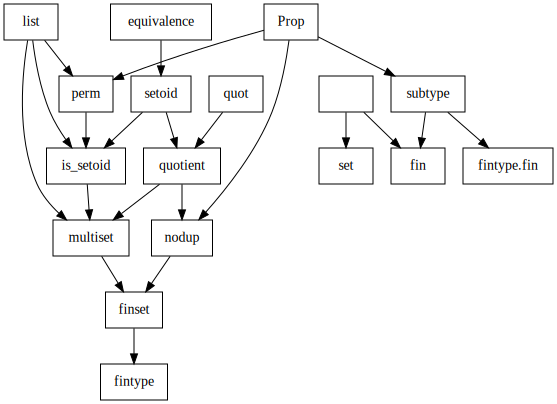

In [13]:
show(e)

## Digging into $[0,\infty]$

We're going to go from simplest to most complex to finally define the type `ennreal`.

#### nontrivial
Predicate typeclass for expressing that a type is not reduced to a single element. In rings,
this is equivalent to `0 ≠ 1`. In vector spaces, this is equivalent to positive dimension.
```
class nontrivial (α : Type*) : Prop :=
(exists_pair_ne : ∃ (x y : α), x ≠ y)
```

*Example 1.*: $\{0,1,2\}$ is nontrivial
```
import data.finset.basic

def X := fin 3

instance : nontrivial X := fin.nontrivial
```

*Example 2.*: Subsets of $\{0,1,2\}$ are nontrivial
```
import data.finset.basic

def X := fin 3

instance : nontrivial (set X) := 
begin
  refine nontrivial_of_ne _ _ _,
  exact set.univ,
  exact ∅ ,
  exact set.empty_ne_univ.symm,
end
```

#### +
```
class has_add      (α : Type u) := (add : α → α → α)
```

*Example 1*.  $\{0,1,2\}$ has add

```
import data.finset.basic
def X := fin 3
instance X_has_add : has_add X := fin.has_add
#check X_has_add -- X_has_add : has_add X

```

*Example 2*.  $\{0,1,2\}$ has add
```
import data.finset.basic
def X := fin 3
def plus (x y : set X) : set X := (x ∪ y : set X)
instance PX_has_add : has_add (set X):= ⟨ plus ⟩ 
#check PX_has_add -- X_has_add : has_add X
```

#### add_semigroup

An additive semigroup is a type with an associative `(+)`.
```
@[protect_proj, ancestor has_add] class add_semigroup (G : Type u) extends has_add G :=
(add_assoc : ∀ a b c : G, a + b + c = a + (b + c))
```
[Example 1](https://www.mi.fu-berlin.de/math/groups/ag-logik/Lehre/UST-chapter01.pdf): Subsets of $\{0,1,2\}$ with union

```
import data.finset.basic
def X := fin 3
def plus (x y : set X) : set X := (x ∪ y : set X)
instance X_has_add : has_add (set X) := ⟨ plus ⟩
theorem X_add_assoc (x y z : set X) :  (x + y) + z = x + (y + z) := sup_assoc
instance X_add_semigroup : add_semigroup (set X) := ⟨ plus, X_add_assoc ⟩ 

```

*Example 2*: Natural numbers with addition
```
import algebra.group.defs
import data.nat.basic
def X := ℕ 
instance X_add_semigroup : add_semigroup X := nat.add_semigroup
#check X_add_semigroup -- X_has_add_semigroup : add_semigroup X
```


In [15]:
e=[('has_add', 'add_semigroup')]

#### *
```
class has_mul      (α : Type u) := (mul : α → α → α)
```

*Example*: $\{0,1,2\}$ with multiplication
```
import data.finset.basic
def X := fin 3
instance X_has_mul : has_mul X := fin.has_mul
```

*Example*: Subsets of $\{0,1,2\}$ with intersection
```
import data.finset.basic
def X := fin 3
def PX_mul (x y : set X) : set X := (x ∩ y : set X)
instance PX_has_mul : has_mul (set X) := ⟨ PX_mul ⟩ 
```

#### semigroup
A semigroup is a type with an associative `(*)`. 
```
@[protect_proj, ancestor has_mul] class semigroup (G : Type u) extends has_mul G :=
(mul_assoc : ∀ a b c : G, a * b * c = a * (b * c))
```
*Example*: Subsets of $\{1,2,3\}$ with intersection

```
import data.finset.basic
def X : set ℕ := ({1, 2, 3} : finset ℕ)
def mul (x y : set X) : set X := (x ∩ y : set X)
instance X_has_mul : has_mul (set X) := ⟨ mul ⟩
theorem X_mul_assoc (x y z : set X) :  (x * y) * z = x * (y * z) := inf_assoc
instance X_semigroup : semigroup (set X) := ⟨ mul, X_mul_assoc ⟩
```

*Example*: Subsets of $\{0,1,2\}$ with intersection (slightly different representation)
```
def X := fin 3
def mul (x y : set X) : set X := (x ∩ y : set X)
instance X_has_mul : has_mul (set X) := ⟨ mul ⟩
theorem X_mul_assoc (x y z : set X) :  (x * y) * z = x * (y * z) := inf_assoc
instance X_semigroup : semigroup (set X) := ⟨ mul, X_mul_assoc ⟩
```

In [16]:
e.extend([('has_mul', 'semigroup')])

#### 1
```
class has_one      (α : Type u) := (one : α)
```

*Example*: $\{0,1,2\}$ with 1
```
import data.finset.basic
def X := fin 3
instance X_has_one : has_one X := fin.has_one
#check X_has_one -- X_has_mul : has_mul X
```

*Example*: Subsets of $\{0,1,2\}$ with $\top$

#### monoid
A `monoid` is a `semigroup` with an element `1` such that `1 * a = a * 1 = a`.
```
@[ancestor semigroup has_one]
class monoid (M : Type u) extends semigroup M, has_one M :=
(one_mul : ∀ a : M, 1 * a = a) (mul_one : ∀ a : M, a * 1 = a)
```

In [17]:
e.extend([('has_one', 'monoid'),
          ('semigroup', 'monoid')])

#### 0
```
class has_zero     (α : Type u) := (zero : α)
```

#### mul_zero_class
Typeclass for expressing that a type `M₀` with multiplication and a zero satisfies
`0 * a = 0` and `a * 0 = 0` for all `a : M₀`.
```
@[protect_proj, ancestor has_mul has_zero]
class mul_zero_class (M₀ : Type*) extends has_mul M₀, has_zero M₀ :=
(zero_mul : ∀ a : M₀, 0 * a = 0)
(mul_zero : ∀ a : M₀, a * 0 = 0)
```

In [18]:
e.extend([('has_mul', 'mul_zero_class'),
          ('has_zero', 'mul_zero_class')])

#### add_monoid
An `add_monoid` is an `add_semigroup` with an element `0` such that `0 + a = a + 0 = a`.
```
@[ancestor add_semigroup has_zero]
class add_monoid (M : Type u) extends add_semigroup M, has_zero M :=
(zero_add : ∀ a : M, 0 + a = a) (add_zero : ∀ a : M, a + 0 = a)
```

In [19]:
e.extend([('has_zero', 'add_monoid'),
          ('add_semigroup', 'add_monoid')])

#### $\leq, <$
```
class has_le       (α : Type u) := (le : α → α → Prop)
class has_lt       (α : Type u) := (lt : α → α → Prop)
```

#### preorder
A preorder is a reflexive, transitive relation `≤` with `a < b` defined in the obvious way.
```
class preorder (α : Type u) extends has_le α, has_lt α :=
(le_refl : ∀ a : α, a ≤ a)
(le_trans : ∀ a b c : α, a ≤ b → b ≤ c → a ≤ c)
(lt := λ a b, a ≤ b ∧ ¬ b ≤ a)
(lt_iff_le_not_le : ∀ a b : α, a < b ↔ (a ≤ b ∧ ¬ b ≤ a) . order_laws_tac)
```

In [20]:
e.extend([('has_le', 'preorder'),
          ('has_lt', 'preorder')])

#### partial_order
A partial order is a reflexive, transitive, antisymmetric relation `≤`.
```
class partial_order (α : Type u) extends preorder α :=
(le_antisymm : ∀ a b : α, a ≤ b → b ≤ a → a = b)
```

In [21]:
e.extend([('preorder', 'partial_order')])

#### linear_order
A linear order is reflexive, transitive, antisymmetric and total relation `≤`.
We assume that every linear ordered type has decidable `(≤)`, `(<)`, and `(=)`. 
````
class linear_order (α : Type u) extends partial_order α :=
(le_total : ∀ a b : α, a ≤ b ∨ b ≤ a)
(decidable_le : decidable_rel (≤))
(decidable_eq : decidable_eq α := @decidable_eq_of_decidable_le _ _ decidable_le)
(decidable_lt : decidable_rel ((<) : α → α → Prop) :=
    @decidable_lt_of_decidable_le _ _ decidable_le)
````

In [22]:
e.extend([('partial_order', 'linear_order')])

#### has_bot
Typeclass for the `⊥` (`\bot`) notation
```
class has_bot (α : Type u) := (bot : α)
```

#### has_top
Typeclass for the `⊤` (`\top`) notation
```
class has_top (α : Type u) := (top : α)
```

#### order_bot
An `order_bot` is a partial order with a minimal element.  (We could state this on preorders, but then it wouldn't be unique so distinguishing one would seem odd.)
```
class order_bot (α : Type u) extends has_bot α, partial_order α :=
(bot_le : ∀ a : α, ⊥ ≤ a)
```

In [23]:
e.extend([('partial_order', 'order_bot'),
          ('has_bot', 'order_bot')])

#### order_top
An `order_top` is a partial order with a maximal element.
  (We could state this on preorders, but then it wouldn't be unique
  so distinguishing one would seem odd.)
```
class order_top (α : Type u) extends has_top α, partial_order α :=
(le_top : ∀ a : α, a ≤ ⊤)
```

In [24]:
e.extend([('partial_order', 'order_top'),
          ('has_top', 'order_top')])

#### add_comm_semigroup
A commutative additive semigroup is a type with an associative commutative `(+)`.
```
@[protect_proj, ancestor add_semigroup]
class add_comm_semigroup (G : Type u) extends add_semigroup G :=
(add_comm : ∀ a b : G, a + b = b + a)
```

In [25]:
e.extend([('add_semigroup', 'add_comm_semigroup')])

#### add_comm_monoid
An additive commutative monoid is an additive monoid with commutative `(+)`. 
```
@[protect_proj, ancestor add_monoid add_comm_semigroup]
class add_comm_monoid (M : Type u) extends add_monoid M, add_comm_semigroup M
```

In [26]:
e.extend([('add_monoid', 'add_comm_monoid'),
          ('add_comm_semigroup', 'add_comm_monoid')])

#### ordered_add_comm_monoid 
An ordered (additive) commutative monoid is a commutative monoid  with a partial order such that
* `a ≤ b → c + a ≤ c + b` (addition is monotone)
* `a + b < a + c → b < c`.
```
@[protect_proj, ancestor add_comm_monoid partial_order]
class ordered_add_comm_monoid (α : Type*) extends add_comm_monoid α, partial_order α :=
(add_le_add_left       : ∀ a b : α, a ≤ b → ∀ c : α, c + a ≤ c + b)
(lt_of_add_lt_add_left : ∀ a b c : α, a + b < a + c → b < c)
```

In [27]:
e.extend([('add_comm_monoid', 'ordered_add_comm_monoid'),
          ('partial_order', 'ordered_add_comm_monoid')])

#### canonically_ordered_add_monoid 
A canonically ordered additive monoid is an ordered commutative additive monoid in which the ordering coincides with the divisibility relation, which is to say, `a ≤ b` iff there exists `c` with `b = a + c`.  This is satisfied by the natural numbers, for example, but not the integers or other ordered groups.
```
@[protect_proj]
class canonically_ordered_add_monoid (α : Type*) extends ordered_add_comm_monoid α, order_bot α :=
(le_iff_exists_add : ∀a b:α, a ≤ b ↔ ∃c, b = a + c)
```

In [28]:
e.extend([('ordered_add_comm_monoid', 'canonically_ordered_add_monoid'),
          ('order_bot', 'canonically_ordered_add_monoid')])

#### canonically_ordered_comm_semiring
A canonically ordered commutative semiring is an ordered, commutative semiring
in which `a ≤ b` iff there exists `c` with `b = a + c`. This is satisfied by the
natural numbers, for example, but not the integers or other ordered groups.
```
class canonically_ordered_comm_semiring (α : Type*) extends
  canonically_ordered_add_monoid α, comm_semiring α :=
(eq_zero_or_eq_zero_of_mul_eq_zero : ∀ a b : α, a * b = 0 → a = 0 ∨ b = 0)
```

In [29]:
e.extend([('canonically_ordered_add_monoid', 'canonically_ordered_comm_semiring'),
          ('comm_semiring', 'canonically_ordered_comm_semiring')])

#### monoid_with_zero
A type `M` is a “monoid with zero” if it is a monoid with zero element, and `0` is left
and right absorbing.
```
@[protect_proj] class monoid_with_zero (M₀ : Type*) extends monoid M₀, mul_zero_class M₀.
```

In [30]:
e.extend([('monoid', 'monoid_with_zero'),
          ('mul_zero_class', 'monoid_with_zero')])

#### distrib
A typeclass stating that multiplication is left and right distributive
over addition. 
```
@[protect_proj, ancestor has_mul has_add]
class distrib (R : Type*) extends has_mul R, has_add R :=
(left_distrib : ∀ a b c : R, a * (b + c) = (a * b) + (a * c))
(right_distrib : ∀ a b c : R, (a + b) * c = (a * c) + (b * c))
```

In [31]:
e.extend([('has_mul', 'distrib'),
          ('has_add', 'monoid_with_zero')])

#### semiring
A semiring is a type with the following structures: additive commutative monoid
(`add_comm_monoid`), multiplicative monoid (`monoid`), distributive laws (`distrib`), and
multiplication by zero law (`mul_zero_class`). The actual definition extends `monoid_with_zero`
instead of `monoid` and `mul_zero_class`. 
```
@[protect_proj, ancestor add_comm_monoid monoid_with_zero distrib]
class semiring (α : Type u) extends add_comm_monoid α, monoid_with_zero α, distrib α
```

In [32]:
e.extend([('add_comm_monoid', 'semiring'),
          ('distrib', 'semiring'),
          ('monoid_with_zero', 'semiring')])

#### comm_monoid
A commutative monoid is a monoid with commutative `(*)`.
```
@[protect_proj, ancestor monoid comm_semigroup]
class comm_monoid (M : Type u) extends monoid M, comm_semigroup M
```

In [33]:
e.extend([('monoid', 'comm_monoid'),
          ('comm_semigroup', 'comm_monoid')])

#### comm_semiring
A commutative semiring is a `semiring` with commutative multiplication. In other words, it is a
type with the following structures: additive commutative monoid (`add_comm_monoid`), multiplicative
commutative monoid (`comm_monoid`), distributive laws (`distrib`), and multiplication by zero law
(`mul_zero_class`).
```
@[protect_proj, ancestor semiring comm_monoid]
class comm_semiring (α : Type u) extends semiring α, comm_monoid α
```

In [34]:
e.extend([('semiring', 'comm_semiring'),
          ('comm_monoid', 'comm_semiring')])

#### has_sup
Typeclass for the `⊔` (`\lub`) notation
```
class has_sup (α : Type u) := (sup : α → α → α)
```

#### has_inf
Typeclass for the `⊓` (`\glb`) notation 
```
class has_inf (α : Type u) := (inf : α → α → α)
```

#### semilattice_sup
A `semilattice_sup` is a join-semilattice, that is, a partial order
  with a join (a.k.a. lub / least upper bound, sup / supremum) operation
  `⊔` which is the least element larger than both factors.
```
class semilattice_sup (α : Type u) extends has_sup α, partial_order α :=
(le_sup_left : ∀ a b : α, a ≤ a ⊔ b)
(le_sup_right : ∀ a b : α, b ≤ a ⊔ b)
(sup_le : ∀ a b c : α, a ≤ c → b ≤ c → a ⊔ b ≤ c)
```

In [35]:
e.extend([('has_sup', 'semilattice_sup'),
          ('partial_order', 'semilattice_sup')])

#### semilattice_inf
A `semilattice_inf` is a meet-semilattice, that is, a partial order
  with a meet (a.k.a. glb / greatest lower bound, inf / infimum) operation
  `⊓` which is the greatest element smaller than both factors.
```
class semilattice_inf (α : Type u) extends has_inf α, partial_order α :=
(inf_le_left : ∀ a b : α, a ⊓ b ≤ a)
(inf_le_right : ∀ a b : α, a ⊓ b ≤ b)
(le_inf : ∀ a b c : α, a ≤ b → a ≤ c → a ≤ b ⊓ c)
```

In [36]:
e.extend([('has_inf', 'semilattice_inf'),
          ('partial_order', 'semilattice_inf')])

#### lattice
A lattice is a join-semilattice which is also a meet-semilattice.
```
class lattice (α : Type u) extends semilattice_sup α, semilattice_inf α
```

In [37]:
e.extend([('semilattice_sup', 'lattice'),
          ('semilattice_inf', 'lattice')])

#### bounded_lattice
A bounded lattice is a lattice with a top and bottom element,
  denoted `⊤` and `⊥` respectively. This allows for the interpretation
  of all finite suprema and infima, taking `inf ∅ = ⊤` and `sup ∅ = ⊥`. 
```
class bounded_lattice (α : Type u) extends lattice α, order_top α, order_bot α
```

In [38]:
e.extend([('lattice', 'bounded_lattice'),
          ('order_bot', 'bounded_lattice'),
          ('order_top', 'bounded_lattice')])

#### Sup
```
class has_Sup (α : Type*) := (Sup : set α → α)
```

#### Inf
```
class has_Inf (α : Type*) := (Inf : set α → α)
```

#### complete_lattice
A complete lattice is a bounded lattice which has suprema and infima for every subset.
```
class complete_lattice (α : Type*) extends bounded_lattice α, has_Sup α, has_Inf α :=
(le_Sup : ∀s, ∀a∈s, a ≤ Sup s)
(Sup_le : ∀s a, (∀b∈s, b ≤ a) → Sup s ≤ a)
(Inf_le : ∀s, ∀a∈s, Inf s ≤ a)
(le_Inf : ∀s a, (∀b∈s, a ≤ b) → a ≤ Inf s)
```

In [39]:
e.extend([('bounded_lattice', 'complete_lattice'),
          ('has_Sup', 'complete_lattice'),
          ('has_Inf', 'complete_lattice')])

#### complete_linear_order
A complete linear order is a linear order whose lattice structure is complete.
```
class complete_linear_order (α : Type*) extends complete_lattice α, linear_order α
```

In [40]:
e.extend([('complete_lattice', 'complete_linear_order'),
          ('linear_order', 'complete_linear_order')])

#### densely_ordered
An order is dense if there is an element between any pair of distinct elements.
```
class densely_ordered (α : Type u) [preorder α] : Prop :=
(dense : ∀a₁ a₂:α, a₁ < a₂ → ∃a, a₁ < a ∧ a < a₂)
```

In [41]:
e.extend([('preorder', 'densely_ordered')])

#### ennreal=$[0,\infty]$, finally
We have that `ennreal` $ = [0,\infty]$, the type of non-negative reals plus $\infty$ so $\{x : x \in ℝ \land x \geq 0\} \bigcup \{\infty\}$.  This is the codomain of a measure.
```
@[derive canonically_ordered_comm_semiring, derive complete_linear_order, derive densely_ordered,
  derive nontrivial]
def ennreal := with_top ℝ≥0
```
We see that $[0,\infty]$ is

* `canonically_ordered_comm_semiring`: A canonically order commutative semiring
* `complete_linear_order`: Has a complete linear order
* `densely_ordered`: Is densely ordered
* `nontrivial`: Is nontrivial

Let's chase these down, and then get back to `measure` after that. These are all basic abstract algebra concepts. I will do a depth-first traversal, because there's a ton of these. To make these easier I will sort them earliest to latest.  As I go along I will make notes in a list `e` of the concept dependencies

In [59]:
e=[('ℝ', 'ennreal'),
   ('canonically_ordered_comm_semiring', 'ennreal'),
   ('complete_linear_order', 'ennreal'),
   ('densely_ordered', 'ennreal'),
   ('nontrivial', 'ennreal')]

### The big picture of $[0,\infty]$

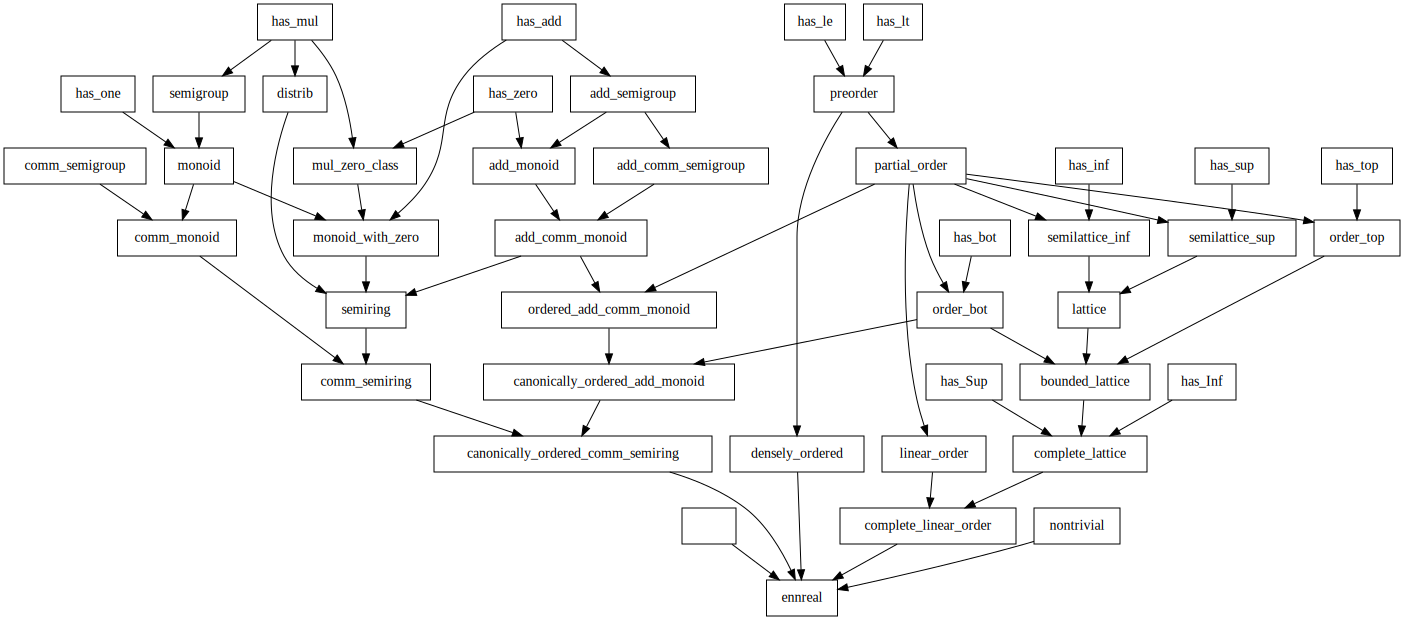

In [42]:
show(e)

## Back to picking apart `measure`

We declared above that `probability_space` **extends** `measure_space`.  So it is a kind of measure space, which means that all of the properties of a measure space hold for a probability space,  plus the extra property $\mu(X)=`$ that we just added.  Let's start drilling down on this.

#### measure_space
A measure space is a measurable space equipped with a measure, referred to as `volume`. 
```
class measure_space (α : Type*) extends measurable_space α :=
(volume : measure α)
```

So a **measure space** is

* A **measurable space** with
* A **measure**, called `volume` for purposes of discussion

In [54]:
e=[('measurable_space', 'measure_space'), ('measure', 'measure_space')]

#### measurable_space
A measurable space is a space equipped with a σ-algebra.
```
structure measurable_space (α : Type*) :=
(is_measurable' : set α → Prop)
(is_measurable_empty : is_measurable' ∅)
(is_measurable_compl : ∀ s, is_measurable' s → is_measurable' sᶜ)
(is_measurable_Union : ∀ f : ℕ → set α, (∀ i, is_measurable' (f i)) → is_measurable' (⋃ i, f i))
```

So there is a carrier set $X$ of type $\alpha$.  We say that there is a $\sigma$-algebra on subsets of $X$.  What that means is defined by 3 axioms and a function `is_measurable'(S)` which says whether a particular set $S$ is in the measurable space or not.  (Also note that the `'` in `is_measurable'` has no special significance, it is a character that you can throw into any name as part of the name, so like $a, a^\prime$, just two slightly different named things.)  The 3 axioms are for inclusion in the measurable space $\Sigma$ are:
|
* `is_measurable' ∅`: The empty set $\emptyset \in \Sigma$.
* `∀ s, is_measurable' s → is_measurable' sᶜ`: For all $S \subseteq X$, if $S \in \Sigma$ then $(X \setminus S) \in \Sigma$.  Typically phrased as "closed under complement".
* `∀ f : ℕ → set α, (∀ i, is_measurable' (f i)) → is_measurable' (⋃ i, f i))`.  let ${\mathscr F} = (F_1,F_2,\ldots)$ be a countable family of subsets $F_i \subseteq X$.  If every $F_i \in \Sigma$, then the countable union $\bigcup_{i\geq 0} F_i \in \Sigma$.  This can be phrased as "closed under countable unions".

The convention in mathematical writing is to call $(X,\Sigma)$ a **measurable space** and to call $\Sigma$ alone a **$\sigma$-algebra**.  To all intents and purposes (and in Lean's implementation in particular), the notions of measurable space and $\sigma$-algebra are synonymous.

In [55]:
e.extend([('set', 'measurable_space'), ('Prop', 'measurable_space')])

#### measure
A `measure` is defined to be an `outer_measure` that is countably additive on
measurable sets, with the additional assumption that the outer measure is the canonical
extension of the restricted measure. 
```
structure measure (α : Type*) [measurable_space α] extends outer_measure α :=
(m_Union ⦃f : ℕ → set α⦄ :
  (∀i, is_measurable (f i)) → pairwise (disjoint on f) →
  measure_of (⋃i, f i) = (∑'i, measure_of (f i)))
(trimmed : to_outer_measure.trim = to_outer_measure)
```
So a measure is defined on a measurable space to be

* An **outer measure** which is **countably additive on measurable sets**, or should I say **additive on countable families of measurable sets**:

```
⦃f : ℕ → set α⦄ : (∀i, is_measurable (f i)) → pairwise (disjoint on f)
```

* Such that the outer measure is the **canonical extension** of the **restricted measure**

```
to_outer_measure.trim = to_outer_measure
```

In [56]:
e.extend([('measurable_space', 'measure'), ('outer_measure', 'measure'), ('ℕ', 'measure')])

#### outer_measure
An outer measure is a countably subadditive monotone function that sends `∅` to `0`
```
structure outer_measure (α : Type*) :=
(measure_of : set α → ennreal)
(empty : measure_of ∅ = 0)
(mono : ∀{s₁ s₂}, s₁ ⊆ s₂ → measure_of s₁ ≤ measure_of s₂)
(Union_nat : ∀(s:ℕ → set α), measure_of (⋃i, s i) ≤ (∑'i, measure_of (s i)))
```

In other words, an outer measure $\mu$ is:
* `set α → ennreal`: A function from subsets of $X$ to the **extended non-negative reals**
* `measure_of ∅ = 0`: Which takes the empty set to 0
* `∀{s₁ s₂}, s₁ ⊆ s₂ → measure_of s₁ ≤ measure_of s₂`: Is **monotone**, so if $A \subseteq B$ then $\mu(A) \leq \mu(B)$

* `∀(s:ℕ → set α), measure_of (⋃i, s i) ≤ (∑'i, measure_of (s i))`: Is **countably subadditive**, so 

$$\mu(\bigcup_{i\geq 0} F_i) \leq \sum_{i_\geq 0} \mu(F_i)$$

In [57]:
e.extend([('set', 'outer_measure'), ('[0,oo]', 'outer_measure')])

### The big picture

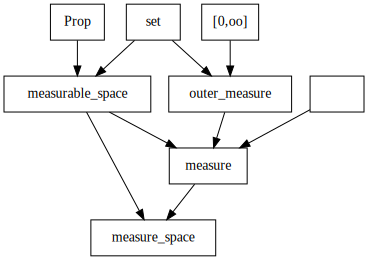

In [58]:
show(e)

## A finite probability space example